In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
#import shap
import pickle
#from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
#from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
import os
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
#from sklearn.neural_network import MLPClassifier
import catboost
from catboost import *
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# sns.set_theme(style="whitegrid")
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [3]:
##### functions
############################################ get importance info ###############################################
def normalize_dataframe(df):
    min_vals = df.min(axis=1)
    max_vals = df.max(axis=1)
    normalized_df = df.sub(min_vals, axis=0).div(max_vals.sub(min_vals, axis=0), axis=0)    
    return normalized_df

     
def get_data_SHAP(method):
    data0 = pd.read_csv(search_path2+method+'/importances_'+method+'.csv',index_col=0)
    data = normalize_dataframe(data0) 
    mean_values = data.mean(axis=0) 
    std_values = data.std(axis=0)
    df0 = pd.DataFrame({'meanvalue':mean_values,'stdvalue':std_values}) 
    df1 = df0.sort_values(by='meanvalue',ascending=False).reset_index(drop=False).rename(columns={'index':'Name'}) 
    df = df1.loc[:K,:]
    return df


def get_data_weight(method):
    data0 = pd.read_csv(search_path1+method+'/importances_'+method+'.csv',index_col=0)
    data = normalize_dataframe(data0)   
    mean_values = data.mean(axis=0) 
    std_values = data.std(axis=0)
    df0 = pd.DataFrame({'meanvalue':mean_values,'stdvalue':std_values}) 
    df1 = df0.sort_values(by='meanvalue',ascending=False).reset_index(drop=False).rename(columns={'index':'Name'})
    df = df1.loc[:K,:]           
    return df

In [4]:
#################################################### auc trend calculate ############################################
### get the auc 95%CI, 
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import utils
from joblib import Parallel, delayed
import lightgbm as lgb
#import shap
from sklearn.model_selection import StratifiedKFold
import xgboost
import os
from sklearn.metrics import precision_recall_fscore_support
import catboost
from catboost import *
import warnings
warnings.filterwarnings('ignore')


############ function ##########################################
 
def model_10cv_XGBoost(X,y):
    #import xgboost
    #from sklearn.model_selection import StratifiedKFold
    #from sklearn import metrics
    skf = StratifiedKFold(n_splits=5)#, random_state=0
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        D_train = xgboost.DMatrix(X_train,label=y_train)
        D_test = xgboost.DMatrix(X_test,label=y_test)
        ###
        params = {
            "eta": 0.01,
            "booster": "gbtree",
            "objective": "binary:logistic",
            "eval_metric":"auc"
        }
        steps = 500  # The number of training iterations
        model = xgboost.train(params, D_train, steps)#
        y_tepred = model.predict(D_test)
        auc_te = metrics.roc_auc_score(y_test, y_tepred)
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====XGBoost model: meanAUC={}'.format(meanAUC))
    print('====XGBoost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)))
    # print('====XGBoost model: meanAUC={}'.format(meanAUC),file=log)
    # print('====XGBoost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY})
    # if os.path.exists(save_path+'/XGBoost/')==False:
    #     os.makedirs(save_path+'/XGBoost/')
    # predict_result.to_csv(save_path+'/XGBoost/predict_result_XGBoost.csv',index=False)
    return predict_result    


def model_10cv_LightGBM(X,y):
    #import lightgbm as lgb
    #from sklearn.model_selection import StratifiedKFold
    #from sklearn import metrics
    skf = StratifiedKFold(n_splits=5)#, random_state=0
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    
    # 获取列名
    feature_names = X.columns

    # 替换非法字符的列名（这里只做替换，不改变原数据）
    safe_feature_names = [name if isinstance(name, str) and name.isalnum() else f"feature_{i}" for i, name in enumerate(feature_names)]
    
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        d_train = lgb.Dataset(X_train,label=y_train, feature_name=safe_feature_names)
        d_test = lgb.Dataset(X_test,label=y_test, feature_name=safe_feature_names)
        ###
        params = {
            #"max_bin": 100,
            "learning_rate": 0.01,
            "boosting_type": "gbdt",
            "objective": "binary",
            "metric": ['auc','binary_logloss'],
            # "is_unbalance": 'True',
            #"num_leaves": 150,
            "verbose": -1,
            #"min_data": 10,
            #"boost_from_average": True
        }
        # callbacks = [lgb.log_evaluation(period=100), lgb.early_stopping(stopping_rounds=50)]
        callbacks = [lgb.log_evaluation(period=100), lgb.early_stopping(stopping_rounds=500)]
        
        model = lgb.train(params, d_train, num_boost_round=1000, valid_sets=[d_test], callbacks=callbacks)
        # model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)
        y_tepred = model.predict(X_test, num_iteration=model.best_iteration)
        auc_te = metrics.roc_auc_score(y_test, y_tepred)
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====LightGBM model: meanAUC={}'.format(meanAUC))
    print('====LightGBM model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)))
    # print('====LightGBM model: meanAUC={}'.format(meanAUC),file=log)
    # print('====LightGBM model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY})
    # if os.path.exists(save_path+'/LightGBM/')==False:
    #     os.makedirs(save_path+'/LightGBM/')
    # predict_result.to_csv(save_path+'/LightGBM/predict_result_LightGBM.csv',index=False)
    return predict_result    


def model_10cv_Catboost(X,y):
    #import catboost
    #from catboost import *
    #from sklearn import metrics
    skf = StratifiedKFold(n_splits=5)
    model = CatBoostClassifier(iterations=500, learning_rate=0.01, verbose=0)#, random_seed=12
    ## note X,y is dataFrame, not array, so .split(X,y) is not right
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        probs = model.predict_proba(X_test)
        y_tepred = probs[:,1]
        auc_te = metrics.roc_auc_score(y_test, y_tepred)
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====Catboost model: meanAUC={}'.format(meanAUC))
    print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)))
    # print('====Catboost model: meanAUC={}'.format(meanAUC),file=log)
    # print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY})
    # if os.path.exists(save_path+'/Catboost/')==False:
    #     os.makedirs(save_path+'/Catboost/')
    # predict_result.to_csv(save_path+'/Catboost/predict_result_Catboost.csv',index=False)
    return predict_result   


def get_auc_95CI(y_true,y_score,n):
    # n is .nf e.g., .3f, .2f
    #from sklearn import metrics
    #from sklearn import utils
    #from joblib import Parallel, delayed      
    def bootstrap_roc_func(i, y_true, y_score):
        yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
        return metrics.roc_curve(yte_true_b, yte_pred_b), metrics.roc_auc_score(yte_true_b, yte_pred_b)

    def get_roc_CI(y_true, y_score,n):
        roc_curves, auc_scores = zip(*Parallel(n_jobs=15)(delayed(bootstrap_roc_func)(i, y_true, y_score) for i in range(100)))    
        # roc_curves, auc_scores = [], []
        # for i in range(1000):
        #     yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
        #     roc_curves.append(metrics.roc_curve(yte_true_b, yte_pred_b))
        #     auc_scores.append(metrics.roc_auc_score(yte_true_b, yte_pred_b))                       
        print('Test ROC AUC: {:.3f}'.format(metrics.roc_auc_score(y_true, y_score)))
        print('Test ROC AUC: ({:.3f}, {:.3f}) percentile 95% CI'.format(np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))   
        meanAUC  = np.round(metrics.roc_auc_score(y_true, y_score),n)
        uCI = np.round(np.percentile(auc_scores, 97.5),n)
        dCI = np.round(np.percentile(auc_scores, 2.5),n)
        #roauc_std = np.std(auc_scores)        
        #auc_ROC = {'roc_auc':roauc,'roc_auc_CI':[roauc_dCI,roauc_uCI],'roc_curves':roc_curves} 
        #allAUC = str(meanAUC)+'['+str(dCI)+', '+str(uCI)+']'       
        return meanAUC, dCI, uCI       
    meanAUC, dCI, uCI = get_roc_CI(y_true, y_score,n)        
    return meanAUC, dCI, uCI
    

#################
def main_function(X,y,method,k,n):
    ## get feature name based on the top k feature
    imp = pd.read_csv(search_path+method+'_imp.csv')
    ind = imp.loc[:k,'Name']
    XX = X.loc[:,ind]
    if method in ['LightGBM_SHAP','LightGBM']:    
        predict_result = model_10cv_LightGBM(XX,y)  #predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY})
    elif method in ['XGBoost_SHAP','XGBoost']:
        predict_result = model_10cv_XGBoost(XX,y)
    elif method in ['Catboost_SHAP','Catboost']:
        predict_result = model_10cv_Catboost(XX,y) 
    else:
        print('Wrong input!!!')             
    meanAUC, dCI, uCI = get_auc_95CI(predict_result['y_test'],predict_result['y_tepred'],n)
    print('====== k=%d, auc=%.3f ' %(k,meanAUC))
    return meanAUC, dCI, uCI

In [5]:
################################################ get trend info ###################################################
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

def get_imp(method):
    temp = pd.read_csv(search_path1 + method + '_imp.csv')
    imp_data = temp[['meanvalue', 'stdvalue']]
    return imp_data

def get_auc(method):
    auc_data = pd.read_csv(search_path2 + method + '_auc_95CI_trend.csv')
    return auc_data

def get_trend_data(method):
    imp_data = get_imp(method)
    auc_data = get_auc(method)
    x = auc_data['topK'][:K]
    imp_mean = imp_data['meanvalue'][:K]
    imp_std = imp_data['stdvalue'][:K]
    auc_mean = auc_data['meanAUC'][:K]
    auc_dci = auc_data['dCI'][:K]
    auc_uci = auc_data['uCI'][:K]
    return x, imp_mean, imp_std, auc_mean, auc_dci, auc_uci

## MIMIC

In [ ]:
# config
db = 'MIMIC'
home = './'
cd = home + db + '/' + db +'_Feature_selection_2/' 
search_path1 = cd  # all data features
search_path2 = home + db + '/' + db +'_Disease_group_4/get_all_subgroup/' 
search_path3 = home + db + '/' + db +'_Disease_group_4/get_disease_group/' 
# save_path
cd2 = r'./2-get_feature_importance/'

In [ ]:
def filter_missing_data(rawdata): 
    # Calculate the number of missing values for each column
    missing_data = rawdata.isnull().sum()
    
    # Calculate missing rate
    missing_rate = missing_data / len(rawdata) * 100
    
    # print(missing_rate.sort_values(ascending=False))
    
    # # Filter columns with missing rate <= 80%
    # filtered_columns = missing_rate[missing_rate <= 80].index
    
    # print(missing_rate[missing_rate < 100].sort_values(ascending=False))
    # Filter columns with missing rate < 100%
    filtered_columns = missing_rate[missing_rate < 100].index
    # filtered_columns = missing_rate[missing_rate <= 99].index
    
    # Return filtered data
    filtered_data = rawdata[filtered_columns]
    
    return filtered_data

def get_raw_data(name, feature_type_num=1, removeICU=False):
    
    try:
        disIDandIHM = pd.read_csv(search_path2 + name + '/patientID.csv')
    except:
        disIDandIHM = pd.read_csv(search_path3 + name + '/patientID.csv')
    
    demo = pd.read_csv(cd + 'fs_demographic_1/' + 'fs_demographic.csv')
    
    triage = pd.read_csv(cd + 'fs_triage_2/' + 'fs_triage.csv')
    
    edlos = pd.read_csv(cd + 'fs_edlos_IHM_3/' + 'fs_edlos_IHM.csv')
    edlos = edlos.drop(['IHM time (hour)', 'IHM'], axis=1)
    
    vitalsign = pd.read_csv(cd + 'fs_vitalsign_4/' + 'fs_vitalsign.csv')
    
    labtest = pd.read_csv(cd + 'fs_labtest_5/' + 'fs_labtest_all_var.csv')  # All variables, missing values not filled
    
    # diagnosis = pd.read_csv(cd + 'fs_diagnosis_6/' + 'fs_diagnosis_dropcount0.csv') # Remove samples where all diagnosis values are 0
    # diagnosis = pd.read_csv(cd + 'fs_diagnosis_6/' + 'fs_diagnosis_fill0.csv')
    pivot_icd_macro = home + db + '/' + db + '_Clean_data_1/Clean_data_result_' + db + '/Clean_' + db + '_diagnosis_pivotICDmacro_3.csv'
    diagnosis = pd.read_csv(pivot_icd_macro)
    diagnosis = diagnosis.rename(columns={'stay_id': 'stay_ID', 'subject_id': 'patient_ID'})
    diagnosis = diagnosis.fillna(value=0)
    diagnosis = diagnosis.drop(['hadm_id'], axis=1)  # MIMIC data has an extra column hadm_id
    for col in diagnosis.columns[2:]:
        diagnosis[col] = diagnosis[col].apply(lambda x: 1 if x >= 1 else x)
    
    # For now, ignore whether p-values are significant
    if feature_type_num == 1:  # demo only
        rawdata = disIDandIHM.merge(demo)
    elif feature_type_num == 2:  # demo + triage
        rawdata = disIDandIHM.merge(demo).merge(triage)
    elif feature_type_num == 3:  # demo + triage + vitalsign
        rawdata = disIDandIHM.merge(demo).merge(triage).merge(vitalsign)
    elif feature_type_num == 4:  # demo + triage + vitalsign + labtest
        rawdata = disIDandIHM.merge(demo).merge(triage).merge(vitalsign).merge(labtest)
    elif feature_type_num == 5:  # demo + triage + vitalsign + labtest + diagnosis
        rawdata = disIDandIHM.merge(demo).merge(triage).merge(vitalsign).merge(labtest).merge(diagnosis)
    elif feature_type_num == 6:  # demo + triage + vitalsign + labtest + diagnosis + ICU admission + EDLOS + Boarding time
        rawdata = disIDandIHM.merge(demo).merge(triage).merge(vitalsign).merge(labtest).merge(diagnosis).merge(edlos)
        if removeICU:
            rawdata = rawdata.drop(['ICU admission'], axis=1)
        
    rawdata.reset_index(drop=True, inplace=True)
    # Filter columns with missing rate less than n%
    rawdata = filter_missing_data(rawdata)

    # rawdata = del_IQR(rawdata)
    # rawdata.reset_index(drop=True, inplace=True)
        
    return rawdata


In [ ]:
## remove ICU
## demo + triage + vitalsign + labtest + diagnosis + EDLOS + Boarding time
##################################### Data Loading #######################################
name = 'alldata'
## Load data
rawdata = get_raw_data(name, feature_type_num=6, removeICU=True)

##################################### Rename Lab Variables #####################################
lab_columns_file =  './Lab_rename.xlsx'
lab_columns_data = pd.read_excel(lab_columns_file)
lab_columns_data = lab_columns_data[[db, db + '_EN']]
lab_columns_data = lab_columns_data[-lab_columns_data[db].isnull()]
lab_rename_and_miss_num = []

for col, col_rename in zip(lab_columns_data[db], lab_columns_data[db + '_EN']):
    if 'Lab' in col:  # Remove duplicates for some variables that repeat in the middle
        try:
            miss_num = rawdata[col].isnull().sum()
            lab_rename_and_miss_num.append({'col': col, 'col_rename': col_rename, 'miss_num': miss_num})
        except:
            pass

lab_rename_and_miss_num_df = pd.DataFrame(lab_rename_and_miss_num)
lab_rename_and_miss_num_df = lab_rename_and_miss_num_df.sort_values(by=['col_rename', 'miss_num'])  ## After translating to English, some field names are duplicated
# Drop duplicates based on 'col_rename' and keep the first (column with fewer missing values)
lab_rename_and_miss_num_df = lab_rename_and_miss_num_df.drop_duplicates(subset='col_rename', keep='first')
# lab_rename_and_miss_num_df.sort_values(by=['col_rename','miss_num'])[lab_rename_and_miss_num_df['col_rename']=='Lab_Whole blood routine_Hematocrit']

# Get the 'col' column from lab_rename_and_miss_num_df (columns to retain)
valid_columns = lab_rename_and_miss_num_df['col'].values

# Filter columns in rawdata that contain 'Lab' but are not in valid_columns
columns_to_remove = [col for col in rawdata.columns if 'Lab' in col and col not in valid_columns]

# Remove these columns from rawdata
rawdata = rawdata.drop(columns=columns_to_remove)

# Create a rename dictionary
lab_rename = dict(zip(lab_rename_and_miss_num_df['col'], lab_rename_and_miss_num_df['col_rename']))

# Rename columns and shuffle the dataset
rawdata = rawdata.rename(columns=lab_rename)
rawdata = rawdata.sample(frac=1, random_state=3).reset_index(drop=True)  ## Shuffle order

##################################### datax + datay #####################################
# for col in rawdata.columns:
#     print(col)
datax = rawdata.iloc[:, 3:] 
print(f'Number of features: {datax.shape[1]}')
datay = rawdata['IHM']
# datax = fillna_mean(datax)
# print(datax.isnull().sum().sort_values())


特征数量: 348


In [ ]:
############################# get topK importance trend ##########################################
db = 'MIMIC'
## input data
cd = r'./'
search_path1 = cd + '/2-get_feature_importance/' + db + '/weight_importance/'
search_path2 = cd + '/2-get_feature_importance/' + db + '/shap_importance/'

save_path = cd +'/3-fs_trend/get_topK_importance_trend/' + db +'/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
methods = ['LightGBM','XGBoost','Catboost']

K = 708 # top K

#method = methods[0]
df1 = get_data_SHAP(methods[0]) 
df1.to_csv(save_path+'LightGBM_SHAP_imp.csv',index=False)
#
df2 = get_data_SHAP(methods[1])
df2.to_csv(save_path+'XGBoost_SHAP_imp.csv',index=False)
    
df3 = get_data_SHAP(methods[2]) 
df3.to_csv(save_path+'Catboost_SHAP_imp.csv',index=False)   
    
df4 = get_data_weight(methods[0])
df4.to_csv(save_path+'LightGBM_imp.csv',index=False)

df5 = get_data_weight(methods[1])  
df5.to_csv(save_path+'XGBoost_imp.csv',index=False)
  
df6 = get_data_weight(methods[2])   
df6.to_csv(save_path+'Catboost_imp.csv',index=False)
# 


In [ ]:
########################################################## auc trend calculate ##################################################
db = 'MIMIC'
cd = r'./'
search_path = cd +'/3-fs_trend/get_topK_importance_trend/' + db +'/'
save_path = cd +'/3-fs_trend/fs_auc_step2-2/get_topK_auc_trend/' + db +'/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
log = open(save_path+'/log_results.txt',mode="a+",encoding="utf-8")

methods = ['LightGBM_SHAP','XGBoost_SHAP','Catboost_SHAP','LightGBM','XGBoost','Catboost']

## 
X,y = datax,datay

n = 3 #.3f
#method = methods[0]

def main(method):
    # for 48hr
    allAUC = []
    alluCI = []
    alldCI = []
    ##
    rg = list(range(1,160+1)) #important len is 708
    # rg = list(range(1,120+1)) #important len is 708
    for k in rg:
        print('=============== k=%d ============='%(k))
        meanAUC, dCI, uCI = main_function(X,y, method,k,n)
        allAUC.append(meanAUC)
        alluCI.append(uCI)
        alldCI.append(dCI)
    ##    
    df = pd.DataFrame({'topK':rg,'meanAUC':allAUC,'dCI':alldCI,'uCI':alluCI})
    df.to_csv(save_path+method+'_auc_95CI_trend.csv',index=False)

In [ ]:
for method in methods:
    main(method)

In [12]:
# method = methods[0]
# main(method)

# method = methods[3]
# main(method)

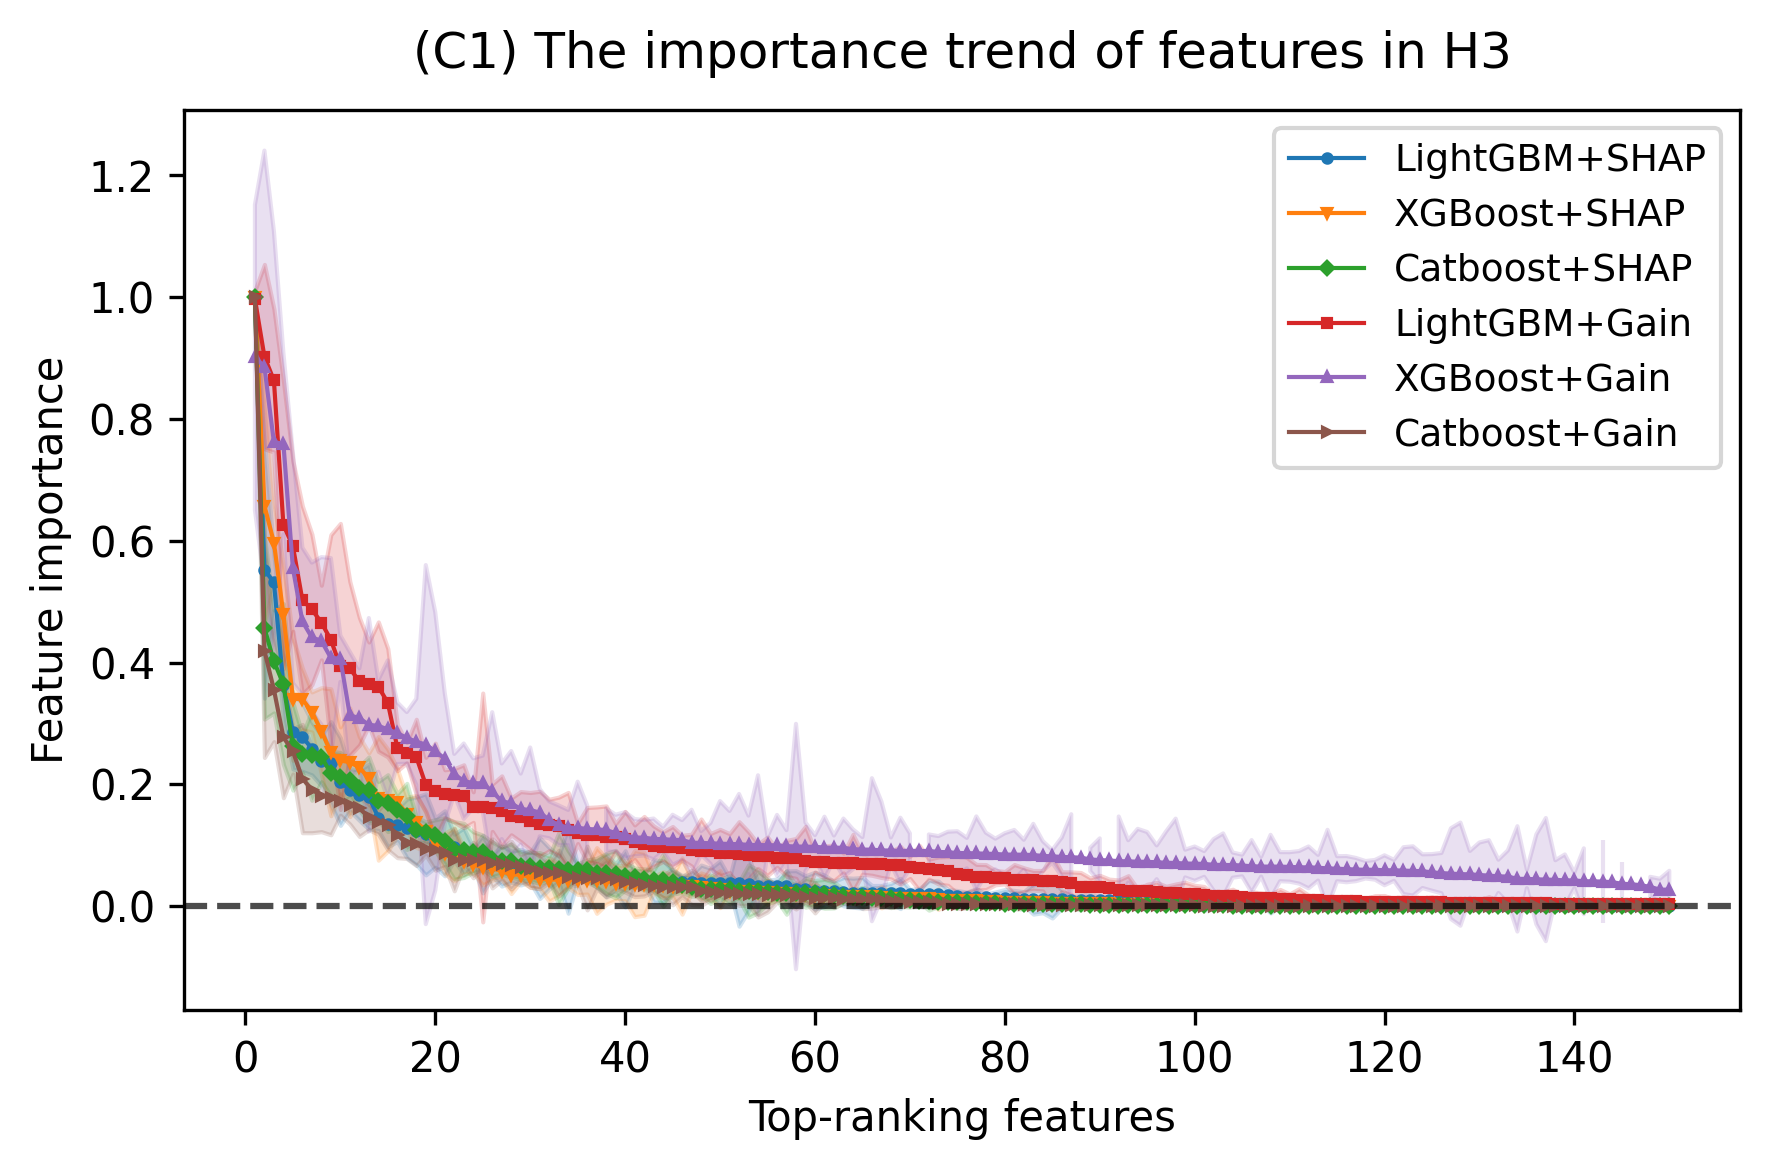

In [ ]:
################################################# importance trend plot #################################################
## input data
db = 'MIMIC'
cd = r'./'
search_path1 = cd +'/3-fs_trend/get_topK_importance_trend/' + db +'/'
search_path2 = cd +'/3-fs_trend/fs_auc_step2-2/get_topK_auc_trend/' + db +'/'
# save_path = cd +'/plot_importance_auc_trend/'

## Methods and styling
methods = ['LightGBM_SHAP', 'XGBoost_SHAP', 'Catboost_SHAP', 'LightGBM', 'XGBoost', 'Catboost']
methodsName = ['LightGBM+SHAP', 'XGBoost+SHAP', 'Catboost+SHAP', 'LightGBM+Gain', 'XGBoost+Gain', 'Catboost+Gain']

# methods = ['LightGBM_SHAP', 'XGBoost_SHAP', 'Catboost_SHAP']
# methodsName = ['LightGBM+SHAP', 'XGBoost+SHAP', 'Catboost+SHAP']

K = 150
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Colors for each method
markers = ['o', 'v', 'D', 's', '^', '>', '<']  # Markers for each method

# Creating the main plots and insets
fig = plt.figure(figsize=(6, 4),dpi=300)
ax1 = plt.subplot(1, 1, 1)

# Plot each method
for i, method in enumerate(methods):
    x, imp_mean, imp_std, auc_mean, auc_dci, auc_uci = get_trend_data(method)
    ax1.plot(x, imp_mean, marker=markers[i], linestyle='-', color=colors[i], lw=1, markersize=2, label=methodsName[i])
    ax1.fill_between(x, imp_mean - 1.96 * imp_std, imp_mean + 1.96 * imp_std, color=colors[i], alpha=0.2)
ax1.set_ylabel('Feature importance', fontsize=10)

if db == 'GDPH':
    ax1.set_title('(A1) The importance trend of features in H1', fontsize=12, pad=10)
elif db == 'SZBA':
    ax1.set_title('(B1) The importance trend of features in H2', fontsize=12, pad=10)
elif db == 'MIMIC':
    ax1.set_title('(C1) The importance trend of features in H3', fontsize=12, pad=10)
    
ax1.set_xlabel('Top-ranking features', fontsize=10)
ax1.axhline(y=0, linestyle='--', color='black', alpha=0.7)


# Add legend and adjust layout
# ax1.legend(loc='center right', fontsize=9)
ax1.legend(loc='upper right', fontsize=9)
plt.grid(False)  
plt.tight_layout()
plt.show()

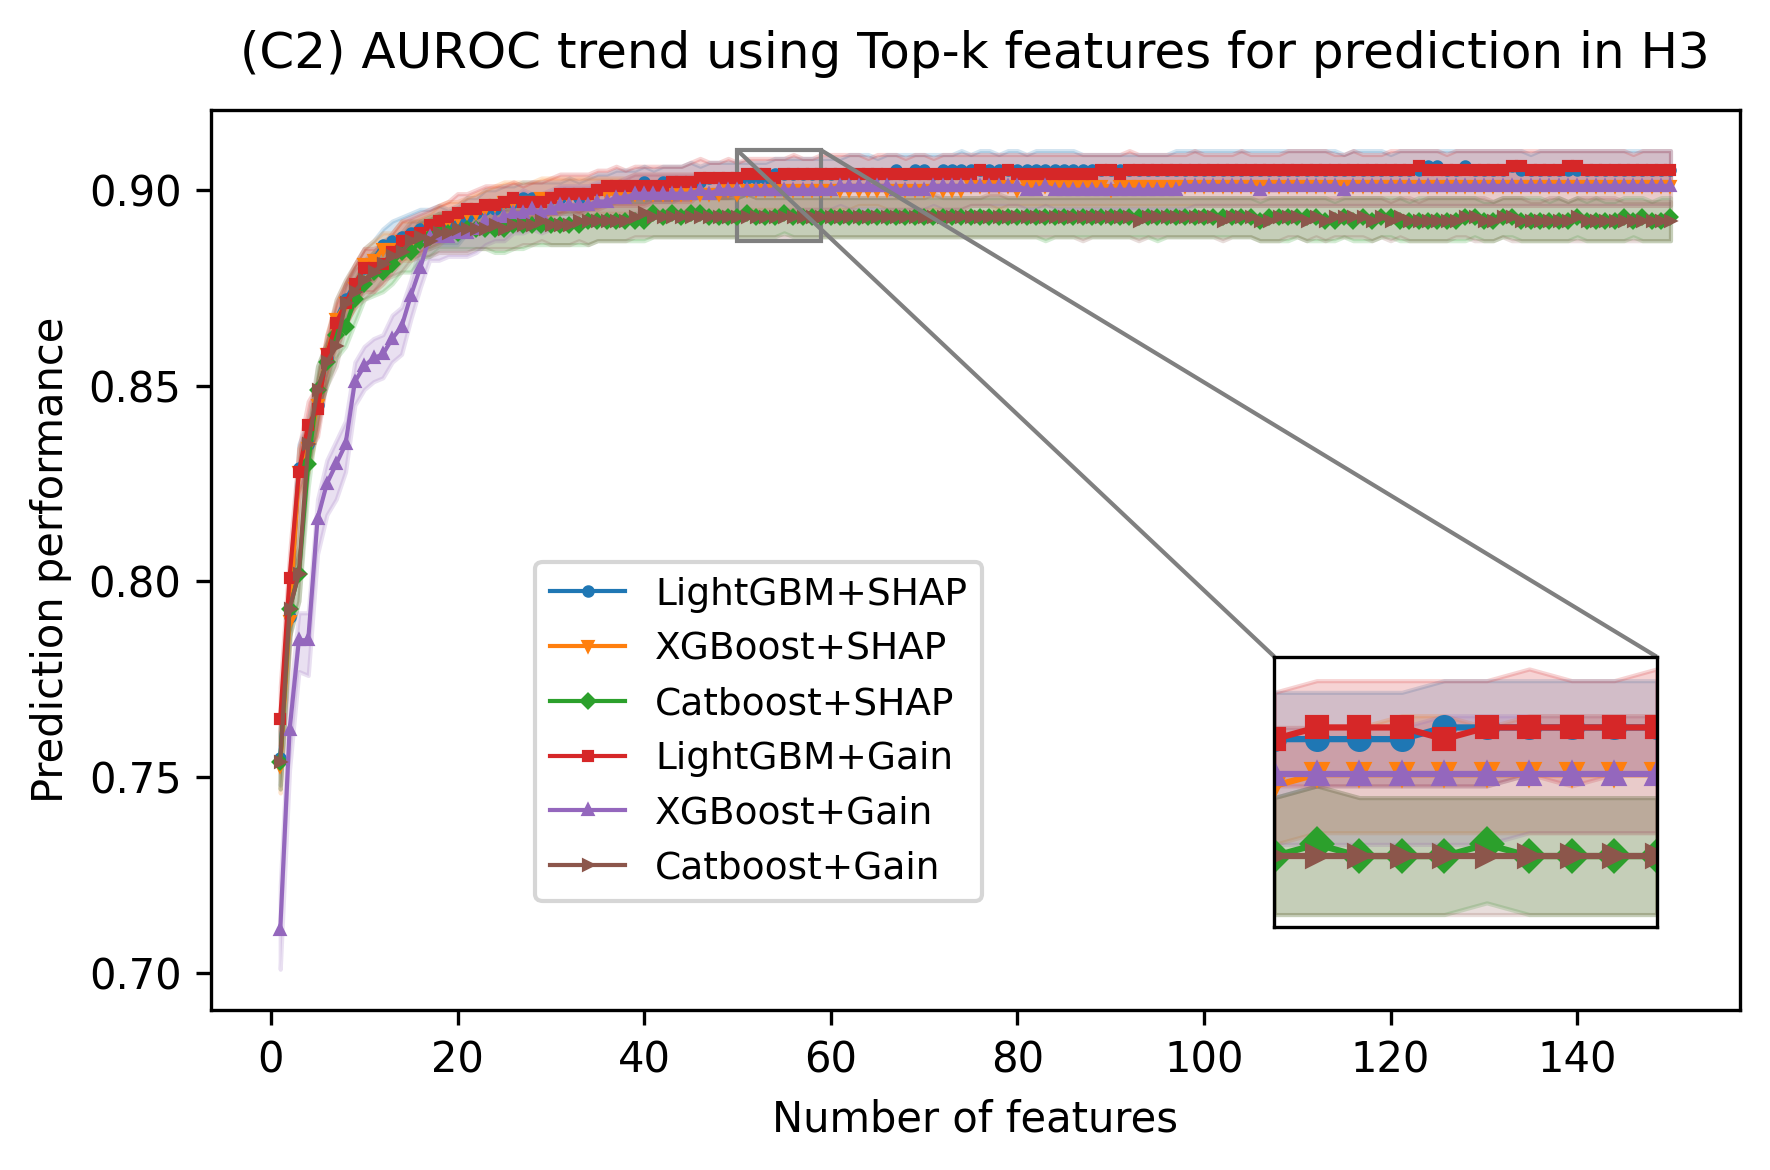

In [ ]:
################################################### auc trend plot ###################################################
## input data
db = 'MIMIC'
cd = r'./'
search_path1 = cd +'/3-fs_trend/get_topK_importance_trend/' + db +'/'
search_path2 = cd +'/3-fs_trend/fs_auc_step2-2/get_topK_auc_trend/' + db +'/'
# save_path = cd +'/plot_importance_auc_trend/'

## Methods and styling
methods = ['LightGBM_SHAP', 'XGBoost_SHAP', 'Catboost_SHAP', 'LightGBM', 'XGBoost', 'Catboost']
methodsName = ['LightGBM+SHAP', 'XGBoost+SHAP', 'Catboost+SHAP', 'LightGBM+Gain', 'XGBoost+Gain', 'Catboost+Gain']

# methods = ['LightGBM_SHAP', 'XGBoost_SHAP', 'Catboost_SHAP']
# methodsName = ['LightGBM+SHAP', 'XGBoost+SHAP', 'Catboost+SHAP']

K = 150
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Colors for each method
markers = ['o', 'v', 'D', 's', '^', '>', '<']  # Markers for each method

# Creating the main plots and insets
fig = plt.figure(figsize=(6, 4),dpi=300)
ax2 = plt.subplot(1, 1, 1)

# Plot each method
for i, method in enumerate(methods):
    x, imp_mean, imp_std, auc_mean, auc_dci, auc_uci = get_trend_data(method)
    ax2.plot(x, auc_mean, marker=markers[i], linestyle='-', color=colors[i], lw=1, markersize=2, label=methodsName[i])
    ax2.fill_between(x, auc_dci, auc_uci, color=colors[i], alpha=0.2)

# ax2.set_ylim(0.64, 0.82)
ax2.set_ylabel('Prediction performance', fontsize=10)

if db == 'GDPH':
    ax2.set_title('(A2) AUROC trend using Top-k features for prediction in H1', fontsize=12, pad=10)
elif db == 'SZBA':
    ax2.set_title('(B2) AUROC trend using Top-k features for prediction in H2', fontsize=12, pad=10)
elif db == 'MIMIC':
    ax2.set_title('(C2) AUROC trend using Top-k features for prediction in H3', fontsize=12, pad=10)
    
ax2.set_xlabel('Number of features', fontsize=10)

# Add an inset to the AUROC trend plot
ax2_inset = inset_axes(ax2, width="25%", height="30%", loc='lower right', borderpad=2)

# Loop over methods to plot in the inset
for i, method in enumerate(methods):
    _, _, _, auc_mean, auc_dci, auc_uci = get_trend_data(method)
    # x1, x2 = 40, 50
    # x1, x2 = 55, 65
    x1, x2 = 50, 60
    x_zoom = range(x1, x2)
    y_zoom = auc_mean[x1-1:x2-1]
    yerr_lower = auc_dci[x1-1:x2-1]
    yerr_upper = auc_uci[x1-1:x2-1]
    ax2_inset.plot(x_zoom, y_zoom, marker=markers[i], linestyle='-', color=colors[i], lw=1.5, markersize=5)
    ax2_inset.fill_between(x_zoom, yerr_lower, yerr_upper, color=colors[i], alpha=0.2)

ax2_inset.set_xlim(x1, x2-1)
ax2_inset.set_xticks([])
ax2_inset.set_yticks([])

mark_inset(ax2, ax2_inset, loc1=1, loc2=2, fc="none", ec='0.5')

# Add legend and adjust layout
ax2.legend(loc='lower left', fontsize=9, bbox_to_anchor=(0.2, 0.1))  
ax2.grid(False)
plt.tight_layout()
plt.show()